<a href="https://colab.research.google.com/github/javier-jaime/Fact-Check-David-Attenborough/blob/main/Update9_BTC_Price_Forecasting_with_yfinance_and_Facebook_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bitcoin Price Forecasting with yfinance and Facebook Prophet**

## Importing all the necessary Libraries

In [1]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.express as px
from fbprophet import Prophet
import plotly.io as pio
pio.renderers.default='colab'

     |████████████████████████████████| 6.4 MB 7.7 MB/s 
     |████████████████████████████████| 63 kB 425 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


## Importing the Dataset & Exploring it

In [2]:
 # Stock Ticker Input
stock = input('Enter the stock ticker: ')
print(f'You entered {stock}, here is the data from the last 10 days:')
period = '2y'
ticker = yf.Ticker(stock)
data = ticker.history(period)
data.reset_index(inplace=True)
data.tail(10)

Enter the stock ticker: BTC-USD
You entered BTC-USD, here is the data from the last 10 days:


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
722,2022-01-31,37920.281250,38647.261719,36733.574219,38483.125000,20734730465,0,0
723,2022-02-01,38481.765625,39115.132812,38113.664062,38743.273438,20288500328,0,0
724,2022-02-02,38743.714844,38834.617188,36832.730469,36952.984375,19155189416,0,0
725,2022-02-03,36944.804688,37154.601562,36375.539062,37154.601562,18591534769,0,0
726,2022-02-04,37149.265625,41527.785156,37093.628906,41500.875000,29412210792,0,0
727,2022-02-05,41501.480469,41847.164062,41038.097656,41441.164062,19652846215,0,0
728,2022-02-06,41441.121094,42500.785156,41244.906250,42412.433594,16142097334,0,0
729,2022-02-07,42406.781250,44401.863281,41748.156250,43840.285156,28641855926,0,0
730,2022-02-08,43854.652344,45293.867188,42807.835938,44118.445312,33079398868,0,0
731,2022-02-09,44053.984375,44577.816406,43249.785156,44513.390625,24511508480,0,0


In [3]:
print('These are the basic stats:')
data.describe()

These are the basic stats:


,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,732.000000,732.000000,732.000000,732.000000,7.320000e+02,732.0,732.0
mean,30958.965477,31795.486040,30027.011513,31000.021474,4.005303e+10,0.0,0.0
std,19232.586402,19738.180822,18628.742513,19216.489068,2.071466e+10,0.0,0.0
min,5002.578125,5331.833984,4106.980957,4970.788086,1.225260e+10,0.0,0.0
25%,10529.751709,10676.360840,10285.792236,10546.611816,2.726173e+10,0.0,0.0
50%,33872.013672,34953.462891,32384.721680,33876.187500,3.618283e+10,0.0,0.0
75%,47780.924805,49161.133789,46678.666992,47729.456055,4.756835e+10,0.0,0.0
max,67549.734375,68789.625000,66382.062500,67566.828125,3.509679e+11,0.0,0.0


# Data Visualization (plotly express) - Visualizing the historical performance

In [4]:
#Line graph (Price), Area graph (Volume) , box plot (Analyzing price and volume)

In [5]:
px.line(data, x="Date", y="Close", title=f'{stock} Stock Close Price')

In [6]:
px.bar(data, x="Date", y="Volume", title=f'{stock} Stock Volume')

In [7]:
px.box(data, y="Close", title=f'{stock} box plot', height=500, width=500)

In [8]:
def get_hurst_exponent(time_series, max_lag=100):
    """Returns the Hurst Exponent of the time series"""
    lags = range(2, max_lag)
    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    return reg[0]

In [9]:
hurst = pd.DataFrame(columns =["hurst_exp","lag"])
lags = range(4, 121, 1)
for lag in lags:
    hurst_exp = get_hurst_exponent(data["Close"].values, lag)
    hurst = hurst.append({"hurst_exp":hurst_exp,"lag":lag},ignore_index=True)
px.line(hurst, x="hurst_exp", y="lag", title=f'{stock} Hurst Exp')

## Data Preparation for Facebook Prophet

In [10]:
columns=['Date','Close']
prophet_df=pd.DataFrame(data,columns=columns)
prophet_df= prophet_df.rename(columns={'Date':'ds','Close':'y'})  
prophet_df.tail()

,ds,y
727,2022-02-05,41441.164062
728,2022-02-06,42412.433594
729,2022-02-07,43840.285156
730,2022-02-08,44118.445312
731,2022-02-09,44513.390625


## Creating Facebook Prophet Model

In [11]:
m=Prophet(daily_seasonality=False)
m.fit(prophet_df)

##Forecasting

In [12]:
periods = 30
future=m.make_future_dataframe(periods)

In [13]:
forecast=m.predict(future)

In [14]:
forecast.head(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-02-09,-1882.342214,1458.845770,8071.522726,-1882.342214,-1882.342214,6684.539286,6684.539286,6684.539286,56.625735,56.625735,56.625735,6627.913550,6627.913550,6627.913550,0.0,0.0,0.0,4802.197071
1,2020-02-10,-1670.950740,2083.348129,8706.202699,-1670.950740,-1670.950740,7175.716909,7175.716909,7175.716909,46.312538,46.312538,46.312538,7129.404371,7129.404371,7129.404371,0.0,0.0,0.0,5504.766169
2,2020-02-11,-1459.559266,2888.281707,9177.284619,-1459.559266,-1459.559266,7539.025351,7539.025351,7539.025351,-58.853303,-58.853303,-58.853303,7597.878655,7597.878655,7597.878655,0.0,0.0,0.0,6079.466085
3,2020-02-12,-1248.167792,3460.538688,9728.792724,-1248.167792,-1248.167792,8073.537477,8073.537477,8073.537477,49.229724,49.229724,49.229724,8024.307753,8024.307753,8024.307753,0.0,0.0,0.0,6825.369685
4,2020-02-13,-1036.776318,4012.234720,10434.659185,-1036.776318,-1036.776318,8320.746777,8320.746777,8320.746777,-79.881861,-79.881861,-79.881861,8400.628637,8400.628637,8400.628637,0.0,0.0,0.0,7283.970458
5,2020-02-14,-825.384844,4492.446030,11060.015951,-825.384844,-825.384844,8703.317401,8703.317401,8703.317401,-16.580025,-16.580025,-16.580025,8719.897425,8719.897425,8719.897425,0.0,0.0,0.0,7877.932556
6,2020-02-15,-613.993371,4974.000592,11695.877254,-613.993371,-613.993371,8979.562891,8979.562891,8979.562891,3.147191,3.147191,3.147191,8976.415700,8976.415700,8976.415700,0.0,0.0,0.0,8365.569521
7,2020-02-16,-402.601897,5566.455440,12071.562137,-402.601897,-402.601897,9222.452793,9222.452793,9222.452793,56.625735,56.625735,56.625735,9165.827057,9165.827057,9165.827057,0.0,0.0,0.0,8819.850896
8,2020-02-17,-191.210423,5573.390799,12380.299678,-191.210423,-191.210423,9331.494583,9331.494583,9331.494583,46.312538,46.312538,46.312538,9285.182045,9285.182045,9285.182045,0.0,0.0,0.0,9140.284160
9,2020-02-18,20.181051,6072.636120,12540.867396,20.181051,20.181051,9274.117134,9274.117134,9274.117134,-58.853303,-58.853303,-58.853303,9332.970437,9332.970437,9332.970437,0.0,0.0,0.0,9294.298186


In [15]:
px.line(forecast, x='ds',y='yhat', title=f'{stock} Stock Forecast')

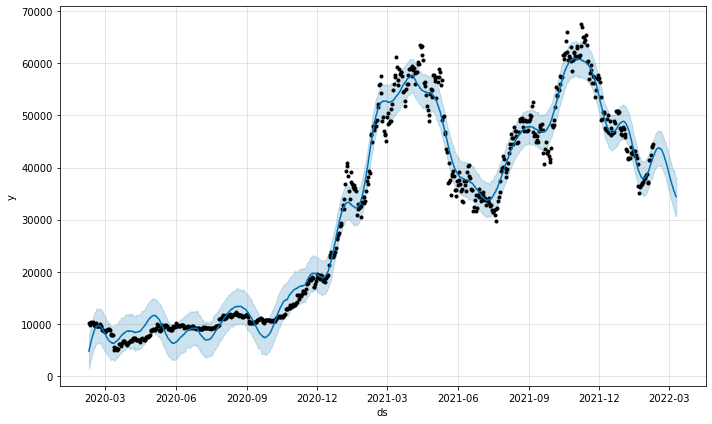

In [16]:
figure=m.plot(forecast, xlabel='ds', ylabel='y')

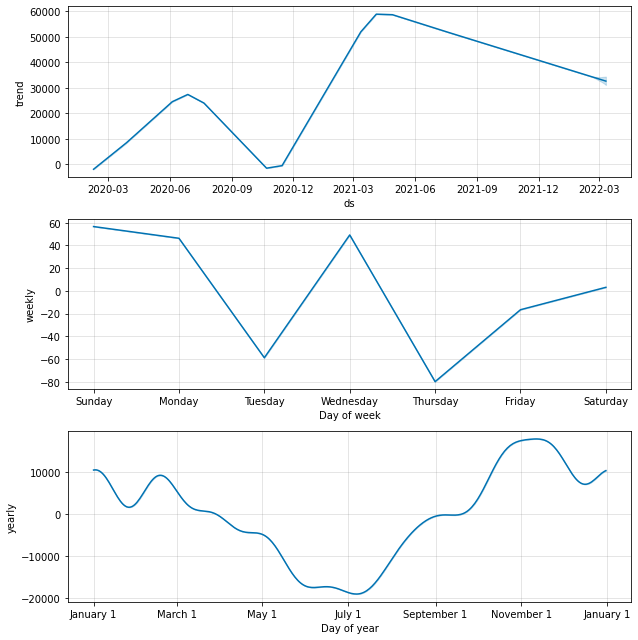

In [17]:
figure2=m.plot_components(forecast)

##Downloading the Forecast data

In [18]:
from google.colab import files
forecast.to_csv(f'{stock}_forecast.csv')
files.download(f'{stock}_forecast.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>